In [1]:
import numpy as np 
import copy
from statistics import correlation
from Ishigami_functions import estimate_sobol, sobol_mc, generate_rvs

import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

### Ishigami Function and Models
$$f(Z) = \sin(Z_{1}) + a\sin^2 (Z_{2}) + b Z_{3}^{4} \sin(Z_{1}), \qquad Z_{i} \sim U(-\pi, \pi). $$


The ANOVA-HDMR unique decomposition of this function is $f(Z) = f_{0} + f_{1}(Z_{1}) + f_{2}(Z_{2}) + f_{13}(Z_{1}, Z_{3})$ with 

$$f_{0} = \frac{a}{2},\\ 
f_{1}(Z_{1}) = \left(1 + b \frac{\pi^4}{5}\right) \sin(Z_{1}),\\
f_{2}(Z_{2}) = a \sin^2(Z_{2}) - \frac{a}{2},\\
f_{1,3}(Z_{1}, Z_{3}) = b \sin(Z_{1}) \left(Z_{3}^4 - \frac{\pi^4}{5}\right),
$$
such that 
$$
\int_{\mathbb{R}} f_{u}(z_{u}) \rho_{u}(z_{u}) \mathrm{d} z_{u} = 0, \qquad \forall u \in \{1, 2, \{1,3\}\}
$$
where $\rho_{u}$ is the density of the random variable $Z$ with index $u$. The expectation of $f(Z)$ can be computed analytically, such that
$$
\mathbb{E}[f(Z)] = \mathbb{E}[f_{0} + f_{1}(Z_{1}) + f_{2}(Z_{2}) + f_{1,3}(Z_{1}, Z_{3})] = \mathbb{E}[f_{0}] + \mathbb{E}[f_{1}(Z_{1})] + \mathbb{E}[f_{2}(Z_{2})] + \mathbb{E}[f_{1,3}(Z_{1}, Z_{3})] = \frac{a}{2}.
$$
Similarly, the variance of $f(Z)$ is
$$
\text{Var}[f(Z)] = \frac{1}{8\pi^3} \int_{-\pi}^{\pi}  \int_{-\pi}^{\pi}   \int_{-\pi}^{\pi} \left(f(Z) - \mathbb{E}[f(z)]\right)^2 \mathrm{d}z_{1} \mathrm{d} z_{2} \mathrm{d} z_{3} = \frac{1}{2} + \frac{a^2}{8} + \frac{\pi^4 b}{5} + \frac{\pi^8 b^2}{18}.
$$
The component variances are 
$$
V_{1} = \text{Var}[f_{1}(Z_{1})] = \frac{1}{2\pi}\int_{-\pi}^{\pi} \left(1 + b\frac{\pi^4}{5}\right)^2 \sin^2(z_{1}) \mathrm{d}z_{1} = \frac{1}{2}\left( 1+ b \frac{\pi^4}{5}\right)^2,\\
V_{2} = \text{Var}[f_{2}(Z_{2})] = \frac{1}{2\pi}  \int_{-\pi}^{\pi} a^2 \left( \sin^2(z_{2}) - \frac{1}{2}\right)^2 \mathrm{d} z_{2} = \frac{a^2}{8},\\
V_{1,3} = \text{Var}[f_{1,3}(Z_{1}, Z_{3})] = \frac{1}{4\pi^2}\int_{-\pi}^{\pi} \int_{-\pi}^{\pi} b^2 \sin^2(z_{1}) \left(z_{3}^4 - \frac{\pi^4}{5}\right)^2 \mathrm{d}z_{1} \mathrm{d}z_{3} =  \pi^8 b^2 \left( \frac{1}{18} - \frac{1}{50}\right).
$$


### References
[1] E. Qian, B. Peherstorfer, D. O’Malley, V. V. Vesselinov, and K. Willcox. Multifidelity monte carlo estimation of variance and sensitivity indices. SIAM/ASA Journal on Uncertainty Quantification, 6(2):683–706, 2018

In [2]:
def f_fun(z1, z2, z3, a=5, b=0.1):
    return np.sin(z1) + a * (np.sin(z2)**2) + b* np.sin(z1) * (z3**4)

def V1_analytic(b):
    return 0.5 * (1 + 1/5 * b * np.pi**4)**2

def V2_analytic(a):
    return (a**2) / 8 

def V13_analytic(b):
    return np.pi**8 * b**2 * (1/18 - 1/50)

def Vt_analytic(a, b):
    return 0.5 + 1/8 * a**2 + 1/5 * np.pi**4 * b + 1/18 * b**2 * np.pi**8 

In [3]:
# set up parameters (deterministic)
a, b = 5, 0.1

# print Sobol indices
print("S1 = ", V1_analytic(b)/ Vt_analytic(a, b))
print("S2 = ", V2_analytic(a)/ Vt_analytic(a, b))
print("S13 = ", V13_analytic(b)/ Vt_analytic(a, b))

S1 =  0.40074256833459065
S2 =  0.28816217057600235
S13 =  0.3110952610894071


The above agrees with the results presented in [1]. 

### Monte-Carlo computation of Sobol indices using HDMR

### Step 1: 
Draw $2N$ samples of $Z_{i} \sim \rho_{i}$ and store in matrices $A$ and $B$.

In [4]:
N = 10**5

z1_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)
z2_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)
z3_samples = np.random.uniform(low=-np.pi, high=np.pi, size=2*N)

In [5]:
A, B = np.zeros((N, 3)), np.zeros((N, 3))
A[:, 0] = z1_samples[:N]
A[:, 1] = z2_samples[:N]
A[:, 2] = z3_samples[:N]

B[:, 0] = z1_samples[N:]
B[:, 1] = z2_samples[N:]
B[:, 2] = z3_samples[N:]

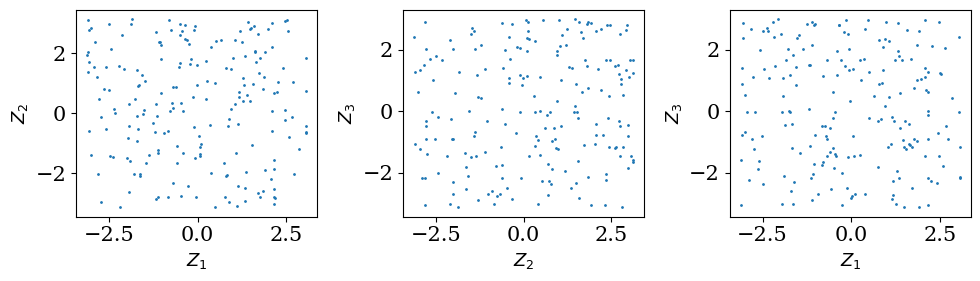

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].scatter(z1_samples[::1000], z2_samples[::1000], s=1)
ax[0].set_xlabel("$Z_{1}$")
ax[0].set_ylabel("$Z_{2}$")

ax[1].scatter(z2_samples[::1000], z3_samples[::1000], s=1)
ax[1].set_xlabel("$Z_{2}$")
ax[1].set_ylabel("$Z_{3}$")

ax[2].scatter(z1_samples[::1000], z3_samples[::1000], s=1)
ax[2].set_xlabel("$Z_{1}$")
ax[2].set_ylabel("$Z_{3}$")
plt.tight_layout()

### Step 2:
Define the new matrix $C^{(i)}$ which is all of $B$ except the $i$th column is replaced by the $i$th column of $A$ so that 


In [7]:
C1, C2, C3 = copy.deepcopy(B), copy.deepcopy(B), copy.deepcopy(B)

In [8]:
C1[:, 0] = A[:, 0]
C2[:, 1] = A[:, 1]
C3[:, 2] = A[:, 2]

### Step 3:
Use the model $Y = f(Z_{1}, Z_{2}, Z_{3})$ to compute the output $Y$ from each of the matricies, i.e. 

In [9]:
YA = f_fun(z1=A[:, 0], z2=A[:, 1], z3=A[:, 2], a=a, b=b) 
YB = f_fun(z1=B[:, 0], z2=B[:, 1], z3=B[:, 2], a=a, b=b) 
YC1 = f_fun(z1=C1[:, 0], z2=C1[:, 1], z3=C1[:, 2], a=a, b=b) 
YC2 = f_fun(z1=C2[:, 0], z2=C2[:, 1], z3=C2[:, 2], a=a, b=b) 
YC3 = f_fun(z1=C3[:, 0], z2=C3[:, 1], z3=C3[:, 2], a=a, b=b) 

### Step 4:
The main effect and total effect sensitivity are 
$$
S_{i} = \frac{\frac{1}{N} y_{A}^{\top}y_{C^{(i)}} - f_{0}^2}{\frac{1}{N} y_{A}^{\top} y_{A} - f_{0}^2}
$$
and the total effect is 
$$
T_{i} = 1 - \frac{\frac{1}{N} y_{B}^{\top}y_{C^{(i)}} - f_{0}^2}{\frac{1}{N} y_{A}^{\top} y_{A} - f_{0}^2}
$$
with 
$f_{0} = \mathbb{E}[Y] \approx \frac{1}{N} \sum_{j=1}^{N} y_{A}^{(j)}$. Variants on the Sobol’ estimator exist, including the Saltelli estimator, Owen estimator, and Janon estimator. 

In [10]:
S, T = estimate_sobol(YA, YB, YC1, YC2, YC3)

In [11]:
print("MC estimate of S1", S[0])
print("(True) S1 = ", V1_analytic(b=b)/ Vt_analytic(a=a, b=b))

MC estimate of S1 0.3991490306900274
(True) S1 =  0.40074256833459065


In [12]:
print("MC estimate of S2 = ", S[1])
print("(True) S2 = ", V2_analytic(a=a)/ Vt_analytic(a=a, b=b))

MC estimate of S2 =  0.2930032436883096
(True) S2 =  0.28816217057600235


In [13]:
print("MC estimate of S3 = ", S[2])
print("(True) S3 = ", 0)

MC estimate of S3 =  0.005252020108459034
(True) S3 =  0


In [14]:
print("MC estimate of S1 total", T[0])
print("(True) S1 = ", (V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b))

MC estimate of S1 total 0.7099924067972059
(True) S1 =  0.7118378294239978


In [15]:
print("MC estimate of S2 total", T[1])
print("(True) S2 = ", (V2_analytic(a=a))/ Vt_analytic(a=a, b=b))

MC estimate of S2 total 0.29609870132314764
(True) S2 =  0.28816217057600235


In [16]:
print("MC estimate of S3 total", T[2])
print("(True) S3 = ", (V13_analytic(b=b))/ Vt_analytic(a=a, b=b))

MC estimate of S3 total 0.3180068186849687
(True) S3 =  0.3110952610894071


## Repeat the analysis to ensure convergence - "law of large numbers"

In [17]:
N_vec = 10**np.arange(1, 9)

In [18]:
S_res, S_tot_res = np.zeros((3, len(N_vec))), np.zeros((3, len(N_vec)))

In [ ]:
jj = 0
for N in N_vec:
    # step 1,2,3,4
    S_res[:, jj], S_tot_res[:, jj] = estimate_sobol(*sobol_mc(*generate_rvs(N=int(N), d=3), f=f_fun))
    # update jj index
    jj +=1

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows=3, sharex=True, figsize=(10, 7))
ax[0, 0].plot(N_vec, S_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 0].plot(N_vec, S_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 0].plot(N_vec, S_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 0].axhline(V1_analytic(b=b)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 0].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 0].axhline(0, c="k", ls="--", label="Analytic")

ax[0, 0].set_xscale("log")
ax[1, 0].set_xscale("log")
ax[2, 0].set_xscale("log")

ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()

ax[0, 0].set_title("$S_{1}$")
ax[1, 0].set_title("$S_{2}$")
ax[2, 0].set_title("$S_{3}$")

ax[0, 1].plot(N_vec, S_tot_res[0, :], "-o", c="r", label="Monte-Carlo")
ax[1, 1].plot(N_vec, S_tot_res[1, :], "-o", c="b", label="Monte-Carlo")
ax[2, 1].plot(N_vec, S_tot_res[2, :], "-o", c="g", label="Monte-Carlo")
ax[0, 1].axhline((V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1, 1].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2, 1].axhline((V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")

ax[0, 1].set_title("$T_{1}$")
ax[1, 1].set_title("$T_{2}$")
ax[2, 1].set_title("$T_{3}$")

ax[0, 1].set_xscale("log")
ax[1, 1].set_xscale("log")
ax[2, 1].set_xscale("log")

ax[0, 1].legend()
ax[1, 1].legend()
ax[2, 1].legend()

ax[2,0].set_xlabel("N")
ax[2,1].set_xlabel("N")

plt.tight_layout()

### Multifidelity Monte-Carlo (MFMC) computation of Sobol indices using HDMR

Lets assume $f^{(1)}, f^{(2)}, \ldots, f^{(K)}$ models that satisfy $|\rho_{1,1}| > \ldots |\rho_{1, K}|$ and have cost satisfying 
$$
\frac{w_{k-1}}{w_{k}} > \frac{\rho_{1, k-1}^{2} - \rho_{1, k}^{2}}{\rho_{1,k}^{2} - \rho_{1,k+1}^2}
$$
for $k=2, \ldots, K$, and the components of $\mathbf{r}^{*} = [r_{1}*, \ldots, r_{K}^{*}]^{\top} $are given by 
$$
r_{k}^{*} = \sqrt{
\frac{w_{1}(\rho_{1,k}^{2} - \rho_{1, k+1}^{2})}{w_{k}(1-\rho_{1,2}^2)}}
$$
then, given a maximum computational budget $p$, the assignments $\alpha_{k}^{*} = \frac{\rho_{1,k} \sigma_{1}}{\sigma_{k}}$ and $m_{1}^{*} = \frac{p}{\mathbf{w}^{\top} \mathbf{r}^{*}}$ and $m_{k}^{*} = m^{*}_{1} r^{*}_{k}$ for $k = 2, \ldots K$ minimize the mean-squared error of the multifidelity mean estimator. 

Now, lets construct surrogates for the ishigami function, 
$$
f^{(1)}(Z) = \sin(Z_{1}) + a\sin^2 (Z_{2}) + b Z_{3}^{4} \sin(Z_{1}) \\
f^{(2)}(Z) = \sin(Z_{1}) + 0.95a\sin^2 (Z_{2}) + b Z_{3}^{4} \sin(Z_{1}) \\
f^{(3)}(Z) = \sin(Z_{1}) + 0.6a\sin^2 (Z_{2}) + 9bZ_{3}^{2} \sin(Z_{1})\\
$$ 

For example, lets try to understand the PCC of the three models. 

In [ ]:
def f_fun2(z1, z2, z3, a=5, b=0.1):
    return np.sin(z1) + 0.95 * a * (np.sin(z2)**2) + b * np.sin(z1) * (z3**4)

def f_fun3(z1, z2, z3, a=5, b=0.1):
    return np.sin(z1) + 0.6* a * np.sin(z2)**2 + 9 * b * np.sin(z1) * (z3**2)

In [ ]:
N = 10**5

z1_samples = np.random.uniform(low=-np.pi, high=np.pi, size=N)
z2_samples = np.random.uniform(low=-np.pi, high=np.pi, size=N)
z3_samples = np.random.uniform(low=-np.pi, high=np.pi, size=N)

In [ ]:
Y1_RES = f_fun1(z1=z1_samples, z2=z2_samples, z3=z3_samples)
Y2_RES = f_fun2(z1=z1_samples, z2=z2_samples, z3=z3_samples)
Y3_RES = f_fun3(z1=z1_samples, z2=z2_samples, z3=z3_samples)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].scatter(Y1_RES, Y2_RES)
ax[1].scatter(Y1_RES, Y3_RES)
ax[0].set_xlabel("$f^{(1)}(Z)$")
ax[0].set_ylabel("$f^{(2)}(Z)$")
ax[1].set_xlabel("$f^{(1)}(Z)$")
ax[1].set_ylabel("$f^{(3)}(Z)$")

ax[0].set_title("PCC = " + str(round(correlation(Y1_RES, Y2_RES), 4)))
ax[1].set_title("PCC = " + str(round(correlation(Y1_RES, Y3_RES), 4)))


plt.tight_layout()

In [ ]:
print(np.std(Y1_RES), np.std(Y2_RES), np.std(Y3_RES))
print(np.mean(Y1_RES), np.mean(Y2_RES), np.mean(Y3_RES))

from the results above, we set $\rho_{1, 1} = 1, \rho_{1,2} = 0.9997, \rho_{1,3} = 0.9465$, and $\sigma_{1} = 3.30367, \sigma_{2} = 3.2567, \sigma_{3} = 3.5288$ .

In [ ]:
w1, w2, w3 = 1, 0.05, 0.001
rho1, rho2, rho3 = 1, correlation(Y1_RES, Y2_RES), correlation(Y1_RES, Y3_RES)
sigma1, sigma2, sigma3= np.std(Y1_RES), np.std(Y2_RES), np.std(Y3_RES)

r1= 1
r2 = np.sqrt(w1*(rho2**2 - rho3**2)/(w2*(1 - rho2**2)))
r3 = np.sqrt(w1*(rho3**2)/(w3*(1 - rho2**2)))

r = np.array([r1, r2, r3])
w = np.array([w1, w2, w3])

d=3
p = 200/(d+2)
m1 = int(p/(w.T @ r))
m2 = int(m1*r2)
m3 = int(m1*r3)

alpha2 = rho2* sigma1/sigma2
alpha3 = rho3* sigma1/sigma3

In [ ]:
print("m1 = ", m1)
print("m2 = ", m2)
print("m3 = ", m3)
print("total m = ", m1 + m2 + m3)


print("computational cost = ", m1*w1 + m2*w2 + m3*w3)
print("paper computational cost = ", 7*w1 + 461*w2 + 9589*w3)
print("computational budget", p)


print("alpha1 = ", 1)
print("alpha2 = ", alpha2)
print("alpha3 = ", alpha3)

The MFMC estimators of the Sobol indicies are 
$$
\hat{V}_{\text{j, mf}} = \hat{V}_{j, m_{1}}  + \sum_{k=2}^{K} \alpha_{k} \left(\hat{V}_{j, m_{k}}^{(k)} -  \hat{V}_{j, m_{k-1}}^{(k)}\right)\\
\hat{T}_{\text{j, mf}} = \hat{T}_{j, m_{1}}  + \sum_{k=2}^{K} \alpha_{k} \left(\hat{T}_{j, m_{k}}^{(k)} -  \hat{T}_{j, m_{k-1}}^{(k)}\right)\\
\hat{V}_{\text{mf}} = \hat{V}_{m_{1}}^{(1)} + \sum_{k=2}^{K} \alpha_{k} \left( \hat{V}_{m_{k}}^{(k)} -  \hat{V}_{m_{k-1}}^{(k)}\right)
$$

In [ ]:
replicate = 100

In [ ]:
mf_sm, mf_st = np.zeros((d, replicate)), np.zeros((d, replicate))
for jj in range(replicate):
    A, B, C1, C2, C3, = generate_rvs(N=int(m3), d=d)
    mf_sm_holder, mf_st_holder = estimate_sobol(*sobol_mc(A[:m1], B[:m1], C1[:m1], C2[:m1], C3[:m1], f=f_fun))

    sm1, st1 = estimate_sobol(*sobol_mc(A[:m2], B[:m2], C1[:m2], C2[:m2], C3[:m2], f=f_fun2))
    sm2, st2 = estimate_sobol(*sobol_mc(A[:m1], B[:m1], C1[:m1], C2[:m1], C3[:m1], f=f_fun2))
    mf_sm_holder += alpha2 * (sm1 - sm2)
    mf_st_holder += alpha2 * (st1 - st2)

    sm1, st1 = estimate_sobol(*sobol_mc(A[:m3], B[:m3], C1[:m3], C2[:m3], C3[:m3], f=f_fun3))
    sm2, st2 = estimate_sobol(*sobol_mc(A[:m2], B[:m2], C1[:m2], C2[:m2], C3[:m2], f=f_fun3))
    mf_sm_holder += alpha3 * (sm1 - sm2)
    mf_st_holder += alpha3 * (st1 - st2)

    mf_sm[:, jj] = mf_sm_holder
    mf_st[:, jj] = mf_st_holder

In [ ]:
mc_sm, mc_st = np.zeros((d, replicate)), np.zeros((d, replicate))
for jj in range(replicate):
    mc_sm[:, jj], mc_st[:, jj] = estimate_sobol(*sobol_mc(*generate_rvs(N=int(p), d=d), f=f_fun))

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].set_xticklabels(["$S^{MF}_{1}$", "$S^{MC}_{1}$"])
_ = ax[0].boxplot([mf_sm[0, :], mc_sm[0, :]], showfliers=False)

ax[1].set_xticklabels(["$S^{MF}_{2}$", "$S^{MC}_{2}$"])
_ = ax[1].boxplot([mf_sm[1, :], mc_sm[1, :]], showfliers=False)

ax[2].set_xticklabels(["$S^{MF}_{3}$", "$S^{MC}_{3}$"])
_ = ax[2].boxplot([mf_sm[2, :], mc_sm[2, :]], showfliers=False)

ax[0].axhline(V1_analytic(b=b)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2].axhline(0, c="k", ls="--", label="Analytic")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
ax[0].set_xticklabels(["$T^{MF}_{1}$", "$T^{MC}_{1}$"])
_ = ax[0].boxplot([mf_st[0, :], mc_st[0, :]], showfliers=False)

ax[1].set_xticklabels(["$T^{MF}_{2}$", "$T^{MC}_{2}$"])
_ = ax[1].boxplot([mf_st[1, :], mc_st[1, :]], showfliers=False)

ax[2].set_xticklabels(["$T^{MF}_{3}$", "$T^{MC}_{3}$"])
_ = ax[2].boxplot([mf_st[2, :], mc_st[2, :]], showfliers=False)

ax[0].axhline((V1_analytic(b=b) + V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[1].axhline(V2_analytic(a=a)/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")
ax[2].axhline((V13_analytic(b=b))/ Vt_analytic(a=a, b=b), c="k", ls="--", label="Analytic")


plt.tight_layout()